In [2]:
%matplotlib inline

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm as tqdm
from torchvision import transforms
from torch import utils
import matplotlib.pyplot as plt
import numpy as np
import os, imageio

import torch
import cv2

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.1.0.dev20230622+cu121  Device: cuda


### Dataloader

In [4]:
torch.set_default_dtype(torch.float64)
torch.set_default_device(device)

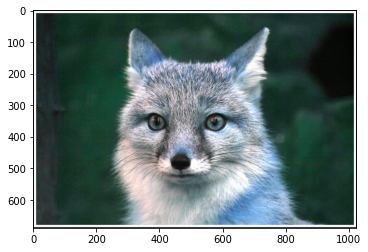

In [5]:
image_url = r"C:/Users/ayush/OneDrive\Desktop/fox.jpg"
img = cv2.imread(image_url)


plt.imshow(img)
plt.show()


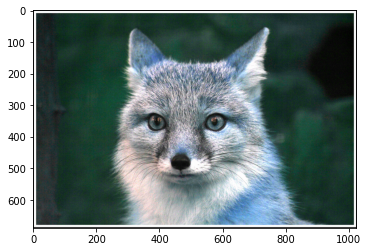

In [6]:
img = cv2.normalize(img, None, 0, 1.0,cv2.NORM_MINMAX, dtype=cv2.CV_64F)

plt.imshow(img)
plt.show()

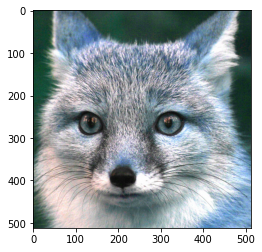

In [7]:
center = [int(img.shape[0]/2),int(img.shape[1]/2)]

r = 256

img = img[ center[0]-r:center[0]+r, center[1]-r:center[1]+r]

plt.imshow(img)
plt.show()

### Converting Dataset

In [8]:
def generate_pixel_coordinates(img):
    
    height, width, _ = img.shape

    # Generate coordinates along the x-axis and y-axis
    x_coords = np.linspace(0, 1, width, endpoint=False)
    y_coords = np.linspace(0, 1, height, endpoint=False)

    # Create a meshgrid of coordinates
    x_mesh, y_mesh = np.meshgrid(x_coords, y_coords)

    # Stack the coordinates and reshape to obtain the final output
    coordinates = np.stack([x_mesh, y_mesh], axis=-1)
    
    return coordinates

### Fourier Feature mapping


In [9]:
def input_mapping(x, B):
    '''
        cos and sin of input are joined together to increased the dimension to 4.
    '''
    if B is None:
        return x
    else:
        B = B.to(x)
        x_proj = (2.*np.pi*x) @ B.T #512,2
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)    #  2*len(B) #512,4

In [10]:
def batch_loader(coord_input,image,map_dict,mapping = 'none'):

    coord_input = input_mapping(coord_input, map_dict[mapping])

    test_data = [coord_input, image]
    train_data = [coord_input[::2], image[::2]]
    
    train_x = torch.tensor(train_data[0]).reshape(-1,coord_input.shape[2]) # because input has 4 dimension
    train_y = torch.tensor(train_data[1]).reshape(-1,3)
    test_x = torch.tensor(test_data[0]).reshape(-1,coord_input.shape[2]) # because input has 4 dimension
    test_y = torch.tensor(test_data[1]).reshape(-1,3)

    return train_x,train_y,test_x,test_y

### MLP network

In [11]:
import torch.nn as nn
import torch.nn.functional as F

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 50) # input has 4 dimensions.
        self.fc1_drop = nn.Dropout(0.2)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(50,3)

    def forward(self, x):
        # x = x.view(-1,4) # input has 4 dimensions.
        x = self.relu1(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.relu2(self.fc2(x))
        x = self.fc2_drop(x)
        return self.fc3(x)

### Alternate Networks

In [13]:
def train_alt():
    
    model.train()


    # Copy data to GPU if needed
    data = train_x
    target = train_y #target.to(device).type(torch.float64)

    # Zero gradient buffers
    optimizer.zero_grad()

    # Pass data through the network
    output = model(data)
    # print(output)


    # Calculate loss
    # print(output.shape,target.shape)
    loss = criterion(output, target)

    # Backpropagate
    loss.backward()

    # Update weights
    optimizer.step()

In [14]:
def validate_alt(epoch,loss_vector, accuracy_vector):
    
    model.eval()
    
    val_loss, correct = 0, 0
    idx = 0
        
    data = test_x
    target = test_y

    output = model(data)
    

    val_loss = criterion(output, target).data.item()
    
    correct = output.eq(target.data).cpu().sum()
        
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32)
    
    accuracy_vector.append(accuracy)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(test_x), accuracy))

    return output

In [15]:
mapping_size = 256

B_dict = {}
# Standard network - no mapping
B_dict['none'] = None
# # Basic mapping
B_dict['basic'] = torch.eye(2)
# # Three different scales of Gaussian Fourier feature mappings
B_gauss = torch.normal(0,1,size=(mapping_size,2))
for scale in [100.]:
    B_dict[f'gauss_{scale}'] = B_gauss * scale

In [16]:
x_test = torch.from_numpy(generate_pixel_coordinates(img))

In [17]:
train_x,train_y,test_x,test_y = batch_loader(x_test,img,B_dict,'basic')

c:\MLAI\lib\site-packages\torch\utils\_device.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


In [18]:
model = Net().to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [26]:
epochs = 200
output_epoch = []


lossv, accv = [], []
for epoch in range(1, epochs + 1):

    train_alt()

    if epoch%10 == 0:
        output_epoch.append(validate_alt(epoch,lossv, accv).reshape(img.shape[0],img.shape[1],3).detach().cpu().numpy())
    else:
        validate_alt(epoch,lossv, accv)


Validation set: Average loss: 0.2916, Accuracy: 0/262144 (0%)


Validation set: Average loss: 0.2900, Accuracy: 0/262144 (0%)


Validation set: Average loss: 0.2885, Accuracy: 0/262144 (0%)


Validation set: Average loss: 0.2870, Accuracy: 0/262144 (0%)


Validation set: Average loss: 0.2854, Accuracy: 0/262144 (0%)


Validation set: Average loss: 0.2839, Accuracy: 0/262144 (0%)


Validation set: Average loss: 0.2823, Accuracy: 0/262144 (0%)


Validation set: Average loss: 0.2808, Accuracy: 0/262144 (0%)


Validation set: Average loss: 0.2792, Accuracy: 0/262144 (0%)


Validation set: Average loss: 0.2777, Accuracy: 0/262144 (0%)


Validation set: Average loss: 0.2761, Accuracy: 0/262144 (0%)


Validation set: Average loss: 0.2745, Accuracy: 0/262144 (0%)


Validation set: Average loss: 0.2730, Accuracy: 0/262144 (0%)


Validation set: Average loss: 0.2714, Accuracy: 0/262144 (0%)


Validation set: Average loss: 0.2698, Accuracy: 0/262144 (0%)


Validation set: Average loss: 0.2683, A

In [27]:
len(output_epoch)

20

In [28]:
import math

In [29]:
# def plot_reconstruction_progress(predicted_images, y):

#   total = len(predicted_images)
#   row = math.ceil(total/10) + 1
#   fig, axs = plt.subplots(row, 10)

#   plt.figure(figsize=(24, 24))

#   # plot the progress of reconstructions
#   for i in range(row-1):
#       for j in range(10):
      
#         axs[i,j].imshow(predicted_images[j].reshape(img.shape[0],img.shape[1],3))

#   y = y.cpu().detach().numpy()
#   axs[-1,0].imshow(y.reshape(img.shape[0],img.shape[1],3))
#   plt.title('GT')
#   plt.axis("off")
#   plt.show()

In [32]:
def plot_reconstruction_progress(predicted_images, y, N=2):

  total = len(predicted_images)
  step = total // N
  plt.figure(figsize=(24, 4))
  print(total,N,total/N)
  # plot the progress of reconstructions
  for i, j in enumerate(range(0,total, step)):
      plt.subplot(1, N, i+1)
      plt.imshow(predicted_images[j])
      plt.axis("off")
      plt.title(f"iter {j}")

  # plot ground truth image
  plt.subplot(1, N+1, N+1)
  y = y.cpu().detach().numpy()
  plt.imshow(y.reshape(img.shape[0],img.shape[1],3))
  plt.title('GT')
  plt.axis("off")
  plt.show()

In [37]:
plt.imshow(output_epoch[20])

IndexError: list index out of range

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20 2 10.0


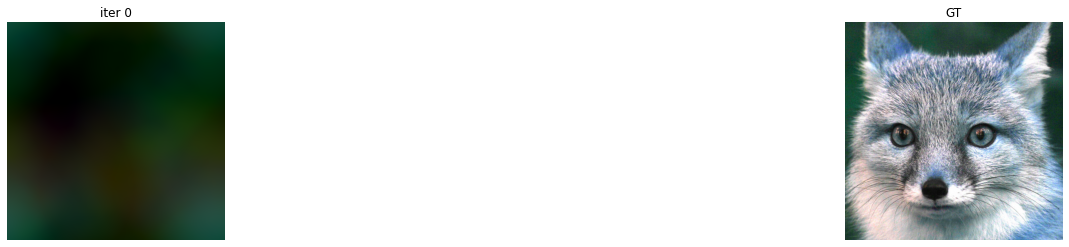

In [33]:
plot_reconstruction_progress(output_epoch,test_y)